# Human Activity Recognition using Clustering


**Integrantes:**
- Lucas Carranza
- Guillermo Sánchez
- David Herencia
- José Osnayo

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob

## Dataset Analysis

### Lectura de los csv
Leemos los archivos .csv que contienen el id único de cada video, y la clase correspondiente para el entrenamiento y validación.

In [6]:
train_path = "data/train_subset_10.csv"
val_path = "data/val_subset_10.csv"
test_path = "data/test_subset_10.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
train_df.head()

,youtube_id,label
0,zeIkGEHK46I,riding camel
1,-Fwy8NwefTk,shot put
2,sDD0p8h88rI,dying hair
3,09AinCnKAE8,riding camel
4,qyTDZajMSqQ,baking cookies


### Análisis de Frecuencias

Analizamos las frecuencias de las apariciones de las clases en la data de entrenamiento para saber si requerimos de consideraciones especiales por desbalanceo.

Observamos que la data de validación se encuentra bien balanceada, mientras que la data de entrenamiento no lo está. El ratio de frecuencias entre la clase con más apariciones 'dying hair' y la clase con menos apariciones 'spraying' es de 2.75 a 1 aproximadamente.

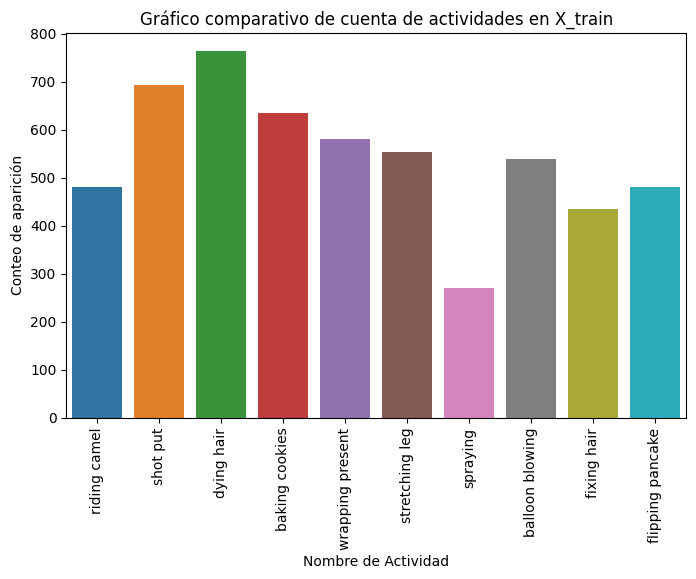

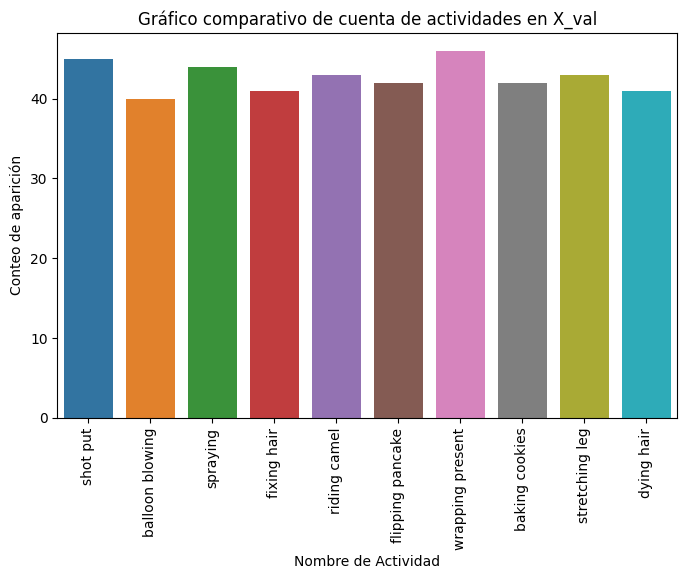

In [33]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_train')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=val_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_val')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')


plt.show()

### Extracción de Features

Utilizamos la librería video_features para extraer el vector característico de cada video, utilizando el modelo R(2+1)D que está especializado en el reconocimiento de actividades.
Para esto necesitamos generar un archivo de texto que contenga las rutas de archivo a cada video a procesar.

In [10]:
# Script para recortar los nombres de cada video a unicamente el id
for directory in ['./data/train_subset', './data/test_subset', './data/val_subset']:
    changed_count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".mp4") and '_' in filename:
            youtube_id = filename.split('_')[0]
            new_filename = f"{youtube_id}.mp4"
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_filename)
            
            ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
            # os.rename(old_file, new_file) 
            # changed_count += 1
    
    print(f"Renaming process for {directory} completed. Updated {changed_count} file names")

Renaming process for ./data/train_subset completed. Updated 0 file names
Renaming process for ./data/test_subset completed. Updated 0 file names
Renaming process for ./data/val_subset completed. Updated 0 file names


In [12]:
# Script para guardar las rutas de los videos en un archivo .txt
paths = []
directory = '/home/lucas/projects/jupyter_nb/HAClustering/data/'
for youtube_id in train_df['youtube_id']:
    paths.append(os.path.join(directory, f"train_subset/{youtube_id}.mp4"))
for youtube_id in val_df['youtube_id']:
    paths.append(os.path.join(directory, f"val_subset/{youtube_id}.mp4"))
for youtube_id in test_df['youtube_id']:
    paths.append(os.path.join(directory, f"test_subset/{youtube_id}.mp4"))

# write to .txt
output_file = './data/paths.txt'
with open(output_file, 'w') as f:
    for path in paths:
        ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
        # f.write(f"{path}\n")

print("Finished writing video paths")

Finished writing video paths


Una vez que ejecutamos el código de la librería video_features y procesamos cada video pot el modelo R(2+1)D, obtenemos una serie de vectores característicos almacenados en un archivo de numpy (.npy), donde cada video tiene su archivo correspondiente. Cada vector característico tiene el formato `{youtube_id}_r21d.npy`.

Leemos y procesamos cada vector característico para almacenarlo en un nuevo dataframe, y eliminamos aquellos vectores que hayan 

In [14]:
feature_path = './feature_vecs/'

def consolidate_features(path, df, return_labels=True):
    features = []
    labels = []
    ids = []
    invalid = 0
    for video in glob.glob(os.path.join(path, '*.npy')):
        youtube_id = os.path.basename(video).split('_')[0]
        current = np.load(video)
        # Skip videos not in df
        if youtube_id not in df['youtube_id'].values:
            continue
        # skip invalid videos
        if current.size == 0:
            invalid += 1
            continue
        features.append(np.mean(current, axis = 0))
        ids.append(youtube_id)
        if return_labels:
            labels.append(df[df['youtube_id'] == youtube_id]['label'].values[0])
    print("# Vectores invalidos: ", invalid)
    features = pd.DataFrame(np.vstack(features))
    ids = pd.DataFrame(np.vstack(ids))
    
    if return_labels:
        labels = pd.DataFrame(np.vstack(labels))
        return features, labels, ids
    else:
        return features, ids

In [16]:
X_train, Y_train, train_ids = consolidate_features(feature_path, train_df)
X_val, Y_val, val_ids = consolidate_features(feature_path, val_df)
X_test, test_ids = consolidate_features(feature_path, test_df, return_labels=False)
print("Finished consolidating feature vectors")
X_train.head()

# Vectores invalidos:  1
# Vectores invalidos:  0
# Vectores invalidos:  0
Finished consolidating feature vectors


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.966334,0.168843,0.623016,0.168297,0.997558,0.567258,0.768725,0.265403,1.569535,0.888397,...,0.302032,1.270000,1.311283,0.315646,0.723442,0.429499,0.469457,0.212127,0.528393,0.850898
1,0.397635,1.175099,0.453327,0.361440,0.446257,0.815945,1.475106,0.823158,0.707716,0.683276,...,0.441201,1.844584,0.760363,1.811300,0.816309,1.187445,1.106697,0.242529,0.394133,0.841067
2,1.476327,0.836213,0.576399,1.638692,1.969499,0.945614,0.825170,0.941553,0.741845,0.207899,...,1.089454,0.620086,0.741715,0.594303,0.694643,0.967789,0.797448,0.357098,0.939564,0.875954
3,0.801088,2.077412,0.716257,0.644899,0.575939,1.697434,0.215660,1.817724,0.211569,1.086203,...,0.977724,1.673636,1.119987,0.481447,0.549719,0.642377,0.831061,0.438447,1.173056,0.282083
4,1.519020,0.338442,0.623273,0.606604,1.269321,0.740866,1.450903,0.703642,1.106854,0.433440,...,0.768131,0.621786,0.492525,1.363047,0.766566,0.849200,0.712595,0.487129,0.363134,1.379261


In [17]:
print("feature vectors  : ", len(X_train) + len(X_val) + len(X_test))
print("original csv len : ", len(train_df) + len(val_df) + len(test_df))
missing_train = len(train_df) - len(X_train)
missing_val = len(val_df) - len(X_val)
missing_test = len(test_df) - len(X_test)

feature vectors  :  6645
original csv len :  6664


## Reducción de Dimensionalidad

### Normalización

Probamos con distintos algoritmos de normalización de la libería scikit-learn para comprobar el impacto de estos en la calidad de los clusters generados al reducir la dimensionalidad.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# scaler = StandardScaler()
scaler = PowerTransformer(method='yeo-johnson')
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
train_numeric_labels, _ = pd.factorize(Y_train[0])
val_numeric_labels, _ = pd.factorize(Y_val[0])

### PCA:
Probamos con el algoritmo de PCA para reducir la dimensionalidad de los vectores característicos, con el fin de hallar el número de componentes necesarios para explicar el 95% de la varianza.

Comprobamos como se ven los clusters tras realizar la reducción de Dimensionalidad, y obtenemos las puntuaciones de sus métricas.

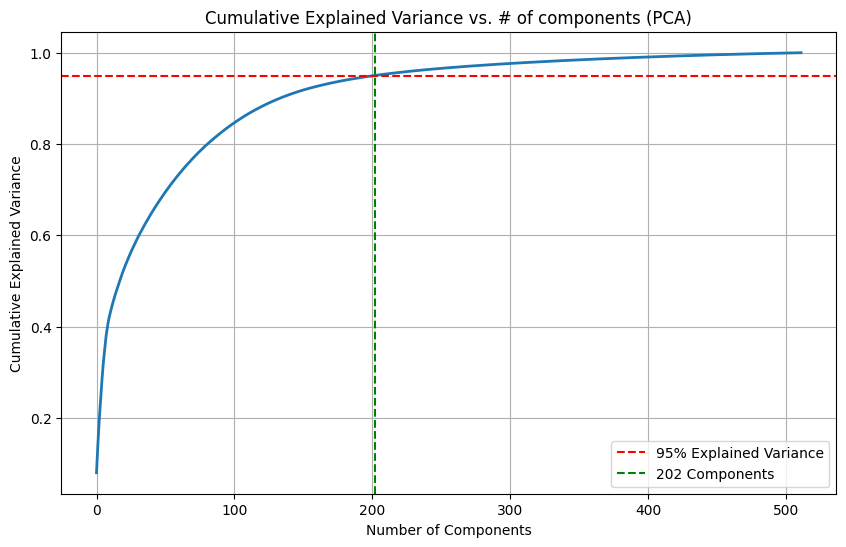

In [26]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
k_pca = np.argmax(cumsum >= 0.95)

plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=k_pca, color='g', linestyle='--', label=f'{k_pca} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. # of components (PCA)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
pca2 = PCA(k_pca)
X_train_pca = pca2.fit_transform(X_train_scaled)
X_val_pca = pca2.transform(X_val_scaled)
X_test_pca = pca2.transform(X_test_scaled)

Silhouette Score for Training Data: 0.13150604904341948
Silhouette Score for Validation Data: 0.08300196615631358


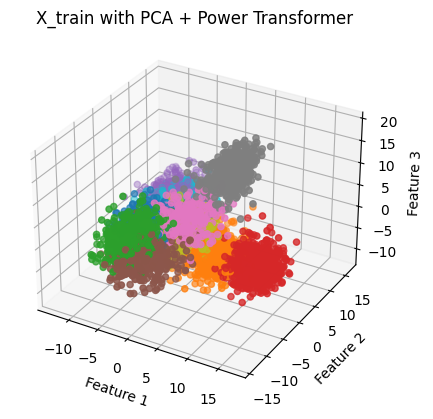

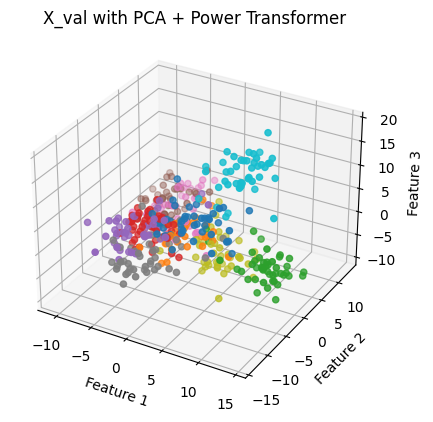

In [22]:
train_numeric_labels, _ = pd.factorize(Y_train[0])
val_numeric_labels, _ = pd.factorize(Y_val[0])

silhouette_train = silhouette_score(X_train_pca, train_numeric_labels)
silhouette_val = silhouette_score(X_val_pca, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

# Plot for X_train
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=train_numeric_labels, cmap='tab10')
ax.set_title("X_train with PCA + Power Transformer")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

# Plot for X_val
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_val_pca[:, 0], X_val_pca[:, 1], X_val_pca[:, 2], c=val_numeric_labels, cmap='tab10')
ax.set_title("X_val with PCA + Power Transformer")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

### Random Projection:

In [41]:
from sklearn.random_projection import GaussianRandomProjection
n_components = 202
random_projection = GaussianRandomProjection(n_components=n_components, random_state=737)

X_train_rp = random_projection.fit_transform(X_train_scaled)
X_val_rp = random_projection.transform(X_val_scaled)
X_test_rp = random_projection.transform(X_test_scaled)

### Laplace embedding:

### UMAP:

Probamos con el algoritmo UMAP para reducir la dimensionalidad drásticamente a 2 o 3 dimensiones.

Librería: [umap-learn](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

In [31]:
from umap import UMAP

umap = UMAP(random_state=737, n_jobs=1)
X_train_umap = umap.fit_transform(X_train_scaled)
X_val_umap = umap.transform(X_val_scaled)
X_test_umap = umap.transform(X_test_scaled)

In [32]:
X_train_umap

array([[11.668623 , 17.676706 ],
       [ 4.2856135,  7.360139 ],
       [ 7.6521344, 14.649853 ],
       ...,
       [15.215488 ,  5.067429 ],
       [16.171812 ,  4.1563993],
       [ 7.4676857, 13.598228 ]], dtype=float32)

Silhouette Score for Training Data: 0.7532395124435425
Silhouette Score for Validation Data: 0.5554121732711792


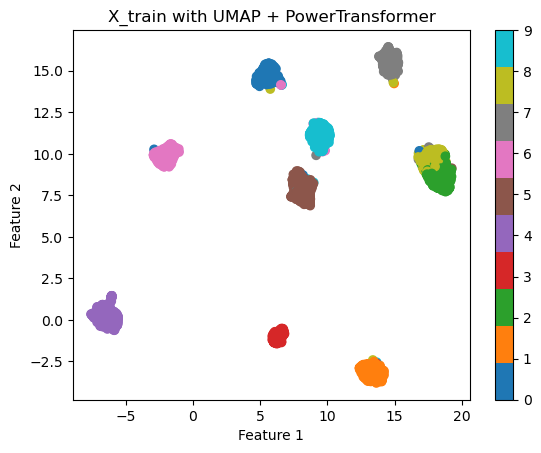

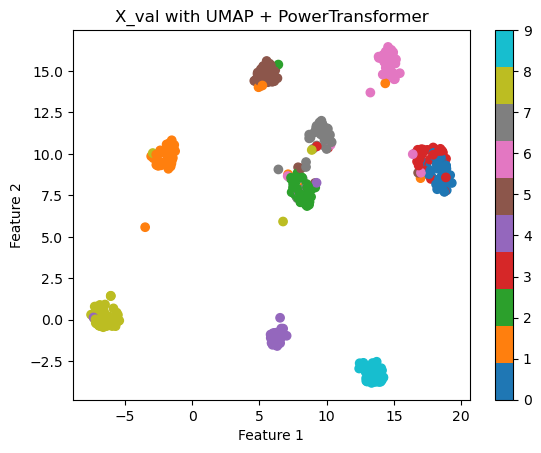

In [318]:
silhouette_train = silhouette_score(X_train_umap, train_numeric_labels)
silhouette_val = silhouette_score(X_val_umap, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

# Plot for X_train
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_train[0])
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=numeric_labels, cmap='tab10')
plt.title("X_train with UMAP + PowerTransformer")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()


# Plot for X_val
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_val[0])
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=numeric_labels, cmap='tab10')
plt.title("X_val with UMAP + PowerTransformer")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

## Implementación

La implementación de los Modelos de Clustering a usar

### Modelo 1: KMeans

Implementamos el modelo KMeans para clusterización con la implementación propia realizada en clase. Esta función retorna las coordenadas de los centroides, así como una lista con los clusters de cada dato.

Para la experimentación probamos con la reducción de dimensionalidad más efectiva (UMAP)

In [36]:
def distance(v1, v2):
    return np.linalg.norm(v1-v2)

def init_Centroide(data, k):
    np.random.seed(737)
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

def return_new_centroide(grupos, data, k):
    new_centroides = []
    for clase in range(k):
        cluster_data = data[grupos == clase]
        if len(cluster_data) > 0:
            new_centroides.append(np.mean(cluster_data, axis=0))
        else:
            new_centroides.append(data[np.random.randint(len(data))])
    return np.array(new_centroides)

def get_cluster(data, centroides):
    grupos = np.zeros(len(data))
    for i in range(len(data)):
      distancias = np.zeros(len(centroides))
      for clase in range(len(centroides)):
        distancias[clase] = distance(data[i], centroides[clase])
      grupos[i] = np.argmin(distancias)
    return grupos

def distancia_promedio_centroides(old_centroides, new_centroides):
    # Initialize array of distances
    promedios = []
    # Iterate each
    for i in range(old_centroides.shape[0]):
        # Get distance between them
        dist = distance(old_centroides[i], new_centroides[i])
        # Append to mean
        promedios.append(dist)
    # Return mean value
    return np.mean(promedios)

def kmeans(data, k, umbral):
  centroides =  init_Centroide(data, k)
  clusters   =  get_cluster(data,centroides)
  new_centroides = return_new_centroide(clusters, data, k)
  while(distancia_promedio_centroides(centroides, new_centroides) > umbral):
     centroides = new_centroides
     clusters   =  get_cluster(data,centroides)
     new_centroides = return_new_centroide(clusters, data, k)

  return new_centroides, clusters

Ejecución del Modelo KMeans:

In [37]:
centroides_train, kmeans_train_labels = kmeans(X_train_umap, 10, 0.01)
centroides_val, kmeans_val_labels = kmeans(X_val_umap, 10, 0.01)
centroides_test, kmeans_test_labels = kmeans(X_test_umap, 10, 0.01)
print(np.unique(kmeans_train_labels, return_counts=True))
print(np.unique(kmeans_val_labels, return_counts=True))
print(np.unique(kmeans_test_labels, return_counts=True))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 692,  809,  110,  578, 1122,  534,  172, 1200,  102,   95]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([18, 83, 84, 84, 29, 25, 36, 22, 25, 20]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([252, 221, 165,  16,  29,   9,  27,  24,  19,  43]))


In [40]:
kmeans_test_labels = kmeans_test_labels.astype(int)
test_df['label'] = kmeans_test_labels
output_csv = "predictions_test.csv"
test_df[['youtube_id', 'label']].to_csv(output_csv, index=False)

Gráficas y métricas para KMeans usando UMAP:

Silhouette Score for Training Data: 0.6670846939086914
Silhouette Score for Validation Data: 0.6946257948875427
Silhouette Score for Test Data: 0.6946257948875427
Adjusted Rand Index for Training Data: 0.7422524563335132
Adjusted Rand Index for Validation Data: 0.5764740171534578


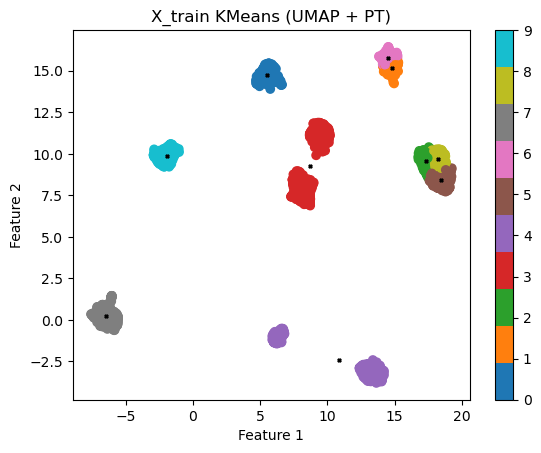

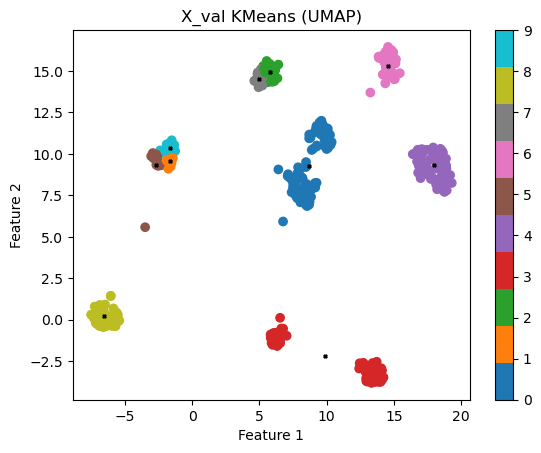

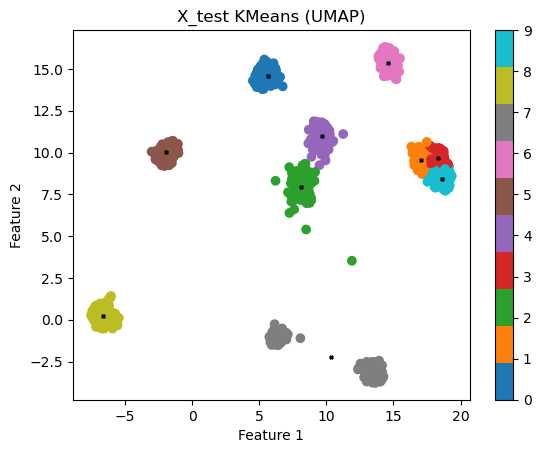

In [317]:
silhouette_train = silhouette_score(X_train_umap, kmeans_train_labels)
silhouette_val = silhouette_score(X_val_umap, kmeans_val_labels)
silhouette_val = silhouette_score(X_test_umap, kmeans_test_labels)
rand_index_train = adjusted_rand_score(Y_train[0], kmeans_train_labels)
rand_index_val = adjusted_rand_score(Y_val[0], kmeans_val_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")
print(f"Silhouette Score for Test Data: {silhouette_val}")
print(f"Adjusted Rand Index for Training Data: {rand_index_train}")
print(f"Adjusted Rand Index for Validation Data: {rand_index_val}")

# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=kmeans_train_labels, cmap='tab10')
plt.title("X_train KMeans (UMAP + PT)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=kmeans_val_labels, cmap='tab10')
plt.title("X_val KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_val[:, 0], centroides_val[:, 1], c='black', marker='X', s=5)
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=kmeans_test_labels, cmap='tab10')
plt.title("X_test KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_test[:, 0], centroides_test[:, 1], c='black', marker='X', s=5)
plt.show()

In [43]:
centroides_train_rp, kmeans_train_labels_rp = kmeans(X_train_rp, 10, 0.01)
centroides_val_rp, kmeans_val_labels_rp = kmeans(X_val_rp, 10, 0.01)
centroides_test_rp, kmeans_test_labels_rp = kmeans(X_test_rp, 10, 0.01)

silhouette_train_rp = silhouette_score(X_train_rp, kmeans_train_labels_rp)
silhouette_val_rp = silhouette_score(X_val_rp, kmeans_val_labels_rp)
rand_index_train_rp = adjusted_rand_score(Y_train[0], kmeans_train_labels_rp)
rand_index_val_rp = adjusted_rand_score(Y_val[0], kmeans_val_labels_rp)

print(f"Silhouette Score for Training Data (RP): {silhouette_train_rp}")
print(f"Silhouette Score for Validation Data (RP): {silhouette_val_rp}")
print(f"Adjusted Rand Index for Training Data (RP): {rand_index_train_rp}")
print(f"Adjusted Rand Index for Validation Data (RP): {rand_index_val_rp}")

Silhouette Score for Training Data (RP): 0.09924765583214323
Silhouette Score for Validation Data (RP): 0.0848776980091958
Adjusted Rand Index for Training Data (RP): 0.78803968645202
Adjusted Rand Index for Validation Data (RP): 0.6255938510952985


In [44]:
kmeans_test_labels_rp = kmeans_test_labels_rp.astype(int)
test_df['label'] = kmeans_test_labels_rp

output_csv = "submission_rp.csv"
test_df[['youtube_id', 'label']].to_csv(output_csv, index=False)

### Modelo 2: DBSCAN

In [64]:
from sklearn.neighbors import KDTree

NINF = -9999
UNDEFINED = -1

def DBSCAN(ds, radio, vecinos_min):
    tree = KDTree(ds)
    n, k = ds.shape
    marked_count = 0
    cluster = [UNDEFINED for _ in range(n)]
    cluster_count = -1

    stack = [0]
    while True:
        if len(stack) == 0:
            try:
                stack.append(cluster.index(UNDEFINED))
            except:
                break
        current_index = stack.pop()

        if cluster[current_index] == UNDEFINED:
            marked_count += 1
            neighbors = tree.query_radius([ds[current_index]], radio)[0]
            n_neighbors = len(neighbors)
            if n_neighbors < vecinos_min:
                cluster[current_index] = NINF
            else:
                cluster_count += 1
                cluster[current_index] = cluster_count
                for v in neighbors:
                    stack.append(v)
                    cluster[v] = cluster_count
        else:
            neighbors = tree.query_radius([ds[current_index]], radio)[0]
            for v in neighbors:
                if cluster[v] == UNDEFINED:
                    marked_count += 1
                    stack.append(v)
                    cluster[v] = cluster_count
                if cluster[v] == NINF:
                    cluster[v] = cluster_count

    return cluster


In [66]:
umap = UMAP(random_state=737, n_jobs=1)
scaler = PowerTransformer(method='yeo-johnson')

X_train_umap = umap.fit_transform(scaler.fit_transform(X_train))
X_val_umap = umap.transform(scaler.transform(X_val))
X_test_umap = umap.transform(scaler.transform(X_test))

In [67]:
radio_umap = 0.5 
vecinos_min_umap = 5  
cluster_train_umap = DBSCAN(X_train_umap, radio_umap, vecinos_min_umap)
cluster_val_umap = DBSCAN(X_val_umap, radio_umap, vecinos_min_umap)

silhouette_train_umap = silhouette_score(X_train_umap, cluster_train_umap)
silhouette_val_umap = silhouette_score(X_val_umap, cluster_val_umap)
ari_train_umap = adjusted_rand_score(Y_train.values.ravel(), cluster_train_umap)
ari_val_umap = adjusted_rand_score(Y_val.values.ravel(), cluster_val_umap)

print(f"Silhouette Score para datos de entrenamiento (UMAP + PT): {silhouette_train_umap}")
print(f"Silhouette Score para datos de validación (UMAP + PT): {silhouette_val_umap}")
print(f"Adjusted Rand Index para datos de entrenamiento (UMAP + PT): {ari_train_umap}")
print(f"Adjusted Rand Index para datos de validación (UMAP + PT): {ari_val_umap}")

Silhouette Score para datos de entrenamiento (UMAP + PT): 0.818498969078064
Silhouette Score para datos de validación (UMAP + PT): 0.7746394276618958
Adjusted Rand Index para datos de entrenamiento (UMAP + PT): 0.8742220816532791
Adjusted Rand Index para datos de validación (UMAP + PT): 0.7658862769905244


In [68]:
cluster_test_umap = DBSCAN(X_test_umap, radio_umap, vecinos_min_umap)
df_predictions_umap = pd.DataFrame({'youtube_id': test_df['youtube_id'].values,
                                    'label': cluster_test_umap[:len(test_df)]})

# Guardar el DataFrame en un archivo CSV
output_csv_umap = './submission_dbscan_umappt.csv'
df_predictions_umap.to_csv(output_csv_umap, index=False)
print(f"CSV con predicciones guardado en: {output_csv_umap}")

CSV con predicciones guardado en: ./submission_dbscan_umappt.csv


In [48]:
n_components_rp = 202
random_projection = GaussianRandomProjection(n_components=n_components_rp, random_state=737)

In [49]:
X_train_rp = random_projection.fit_transform(X_train)
X_val_rp = random_projection.transform(X_val)
X_test_rp = random_projection.transform(X_test)

## Submission

Archivo .csv para la competencia de Kaggle: https://www.kaggle.com/competitions/project-3-clustering